<a href="https://colab.research.google.com/github/Mahedi-Shuvro/seismic-velocity-inversion/blob/main/SeismoLabV3%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This cell connects Colab notebook to
Google Drive for easy file access and storage.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Section 1: Imports and Installations

> installs and imports essential libraries for deep learning (PyTorch and segmentation models), numerical computations, data handling, visualization, and project-specific evaluation utilities. These dependencies form the foundational setup for the deep learning workflow



**Installs**

In [2]:
!pip install anytree  # for creating and manipulating tree data structures in Python.
!pip install segmentation-models-pytorch --quiet # Install necessary libraries for segmentation models

In [3]:
# System & utilities
import os, platform, json, zipfile, random
from glob import glob

# Numerics & viz
import numpy as np
import matplotlib.pyplot as plt

# Progress bar
from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

# Splits
from sklearn.model_selection import train_test_split

# Segmentation Models PyTorch
import segmentation_models_pytorch as smp  # use as smp.DeepLabV3Plus

# Project utilities (assumes utils.py in your working dir / sys.path)
from utils import create_submission, calculate_mape, calculate_score

**Environment & Reproducibility Setup
(Seeds, device, dataset paths)**

In [4]:
# Reproducibility
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Paths (adjust if needed)
train_zip = "/content/drive/MyDrive/Speed_and_Structure/speed-and-structure-train-data.zip"
test_zip  = "/content/drive/MyDrive/Speed_and_Structure/speed-and-structure-test-data.zip"
train_dir = "/content/sample_data/speed-and-structure-train"
test_dir  = "/content/sample_data/speed-and-structure-test"

Using device: cuda


# Data Analysis & Inspection

This cell ensures that train and test datasets are unzipped and ready in the Colab environment, and prints a few file names to verify everything’s in place.

In [5]:
def extract_zip(zip_path, extract_path):
    os.makedirs(extract_path, exist_ok=True)
    if os.listdir(extract_path):
        print(f"✅ Data already extracted at: {extract_path}")
        return
    try:
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(extract_path)
        print(f"✅ Extracted to: {extract_path}")
    except zipfile.BadZipFile:
        print(f"❌ Corrupted zip: {zip_path}")
    except FileNotFoundError:
        print(f"❌ Zip not found: {zip_path}")

extract_zip(train_zip, train_dir)
extract_zip(test_zip, test_dir)

print("📂 Sample training files:", os.listdir(train_dir)[:5])
print("📂 Sample testing files:", os.listdir(test_dir)[:5])

✅ Data already extracted at: /content/sample_data/speed-and-structure-train
✅ Data already extracted at: /content/sample_data/speed-and-structure-test
📂 Sample training files: ['0ju9A6Qb51mOMwFcJ2', '9T67wBqhYLvTN6JC0K', 'U79iL8X6F9X0gRJgAL', '5tJyXE0wyvypSV2KbV', 't8VvZaU5KkkjLlQaZk']
📂 Sample testing files: ['CLmEW3YRpkrQ5gs6Zb', '83zhKrI8SBnzrgnPNn', 'S6gzzKAZ9viROzrRfT', 'KN9ASVjCJQUTXq2fbF', 'p4w2K6FBl039Qp2iCK']


**Dataset Inspection & Sample Exploration
Confirming that input receiver data and target velocity model labels are present and correctly formatted.**

In [6]:
# Path to training samples
train_dir = "/content/sample_data/speed-and-structure-train"
sample_folders = sorted([f for f in glob(os.path.join(train_dir, "*")) if os.path.isdir(f)])
print(f"📦 Total training samples: {len(sample_folders)}")

# Pick one to inspect
sample_path = sample_folders[0]
sample_id = os.path.basename(sample_path)
print(f"\n🔍 Inspecting sample: {sample_id}")

# Load all 5 receiver data inputs
receiver_indices = [1, 75, 150, 225, 300]
for i in receiver_indices:
    file_path = os.path.join(sample_path, f"receiver_data_src_{i}.npy")
    try:
        data = np.load(file_path)
        print(f"Loaded: receiver_data_src_{i}.npy - shape: {data.shape}, dtype: {data.dtype}")
    except FileNotFoundError:
        print(f"Missing file: receiver_data_src_{i}.npy")

# Load the velocity model
vp_path = os.path.join(sample_path, "vp_model.npy")
try:
    vp_model = np.load(vp_path)
    print(f"\n✅ Loaded: vp_model.npy - shape: {vp_model.shape}, dtype: {vp_model.dtype}")
except FileNotFoundError:
   print("Missing file: vp_model.npy")

📦 Total training samples: 2000

🔍 Inspecting sample: 00ady8InZofxhWZsDT
Loaded: receiver_data_src_1.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_75.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_150.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_225.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_300.npy - shape: (10001, 31), dtype: float32

✅ Loaded: vp_model.npy - shape: (300, 1259), dtype: float64


**Visualize Seismic Shot Gather Sample and Ground Truth Velocity Model:
This cell visualizes the five seismic receiver inputs (from different source positions-1,75,250,225,300) and the ground truth velocity model (vp_model.npy) for a selected sample.**

🔍 Visualizing sample at: 00ady8InZofxhWZsDT


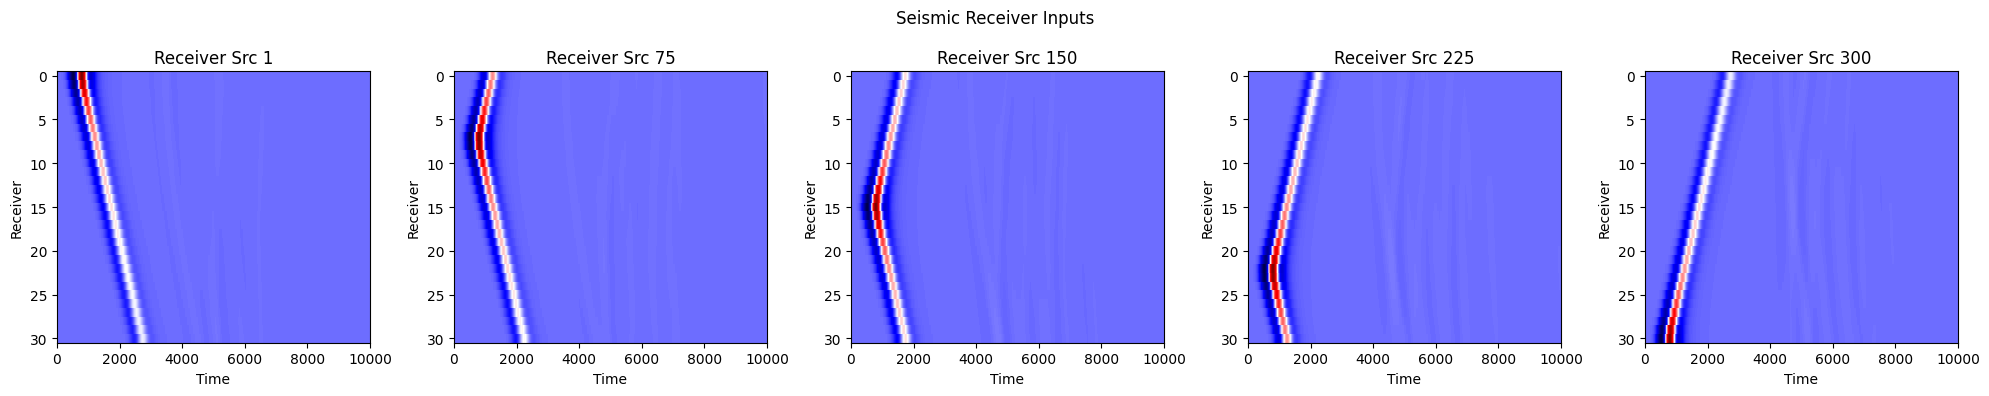

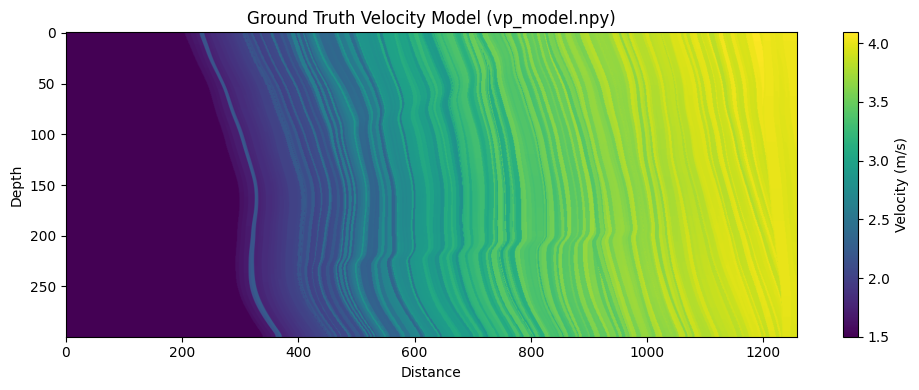

In [7]:
def visualize_sample(sample_path):
    source_positions = [1, 75, 150, 225, 300]
    receiver_data = []

    print(f"🔍 Visualizing sample at: {os.path.basename(sample_path)}")

    # Load seismic receiver inputs with error handling
    for src in source_positions:
        file_path = os.path.join(sample_path, f"receiver_data_src_{src}.npy")
        try:
            data = np.load(file_path)
            receiver_data.append(data)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            receiver_data.append(np.zeros((100, 100)))  # placeholder
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            receiver_data.append(np.zeros((100, 100)))  # placeholder

    # Load velocity model
    try:
        vp_model = np.load(os.path.join(sample_path, "vp_model.npy"))
    except FileNotFoundError:
        print("vp_model.npy not found!")
        return
    except Exception as e:
        print(f"Error loading vp_model.npy: {e}")
        return

    # Plot seismic receiver inputs
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for i, (data, src) in enumerate(zip(receiver_data, source_positions)):
        axs[i].imshow(data.T, aspect='auto', cmap='seismic', interpolation='none')
        axs[i].set_title(f"Receiver Src {src}")
        axs[i].set_xlabel("Time")
        axs[i].set_ylabel("Receiver")
    plt.suptitle("Seismic Receiver Inputs")
    plt.tight_layout()
    plt.show()

    # Plot velocity model
    plt.figure(figsize=(10, 4))
    plt.imshow(vp_model, aspect='auto', cmap='viridis')
    plt.title("Ground Truth Velocity Model (vp_model.npy)")
    plt.xlabel("Distance")
    plt.ylabel("Depth")
    plt.colorbar(label='Velocity (m/s)')
    plt.tight_layout()
    plt.show()


sample_folders = sorted(glob("/content/sample_data/speed-and-structure-train/*"))
visualize_sample(sample_folders[0])



**INSPECT TEST DATA ** the total number of test samples (folders) in the test dataset.

Inspects the first test sample:

Loads and prints the shape and data type for each of the 5 receiver input files (receiver_data_src_*.npy).

Verifies that all necessary input files are present and correctly formatted.

Confirms the test dataset is ready for inference (no ground truth velocity model in test set)

In [8]:
# Path to test samples
test_dir = "/content/sample_data/speed-and-structure-test"
test_folders = sorted([f for f in glob(os.path.join(test_dir, "*")) if os.path.isdir(f)])
print(f"🧪 Total test samples: {len(test_folders)}")

# Pick one to inspect
test_sample_path = test_folders[0]
test_sample_id = os.path.basename(test_sample_path)
print(f"\n🔍 Inspecting test sample: {test_sample_id}")

# Load receiver data (no velocity ground truth in test set)
receiver_indices = [1, 75, 150, 225, 300]
for i in receiver_indices:
    file_path = os.path.join(test_sample_path, f"receiver_data_src_{i}.npy")
    try:
        test_data = np.load(file_path)
        print(f"Loaded: receiver_data_src_{i}.npy - shape: {test_data.shape}, dtype: {test_data.dtype}")
    except FileNotFoundError:
        print(f"Missing file: receiver_data_src_{i}.npy")
    except Exception as e:
        print(f"Error loading receiver_data_src_{i}.npy: {e}")

🧪 Total test samples: 150

🔍 Inspecting test sample: 0BFqBxnVIT368FwmdR
Loaded: receiver_data_src_1.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_75.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_150.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_225.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_300.npy - shape: (10001, 31), dtype: float32


# Data preparation for Training
> PyTorch Dataset for Seismic Shot Gather Inputs and Velocity Models:
This cell defines a custom dataset class to efficiently load, resize, pad, and return seismic receiver data and ground-truth velocity models for use in deep segmentation models. It supports both training/validation (with ground truth) and test (input-only) modes.

In [9]:
class SeismicDataset(Dataset):
    """
    Loads 5 receiver shot gathers per sample, resizes to (300,1259),
    pads to (304,1264), and returns (x, y) for train/val or (x, id) for test.
    """
    def __init__(self, root, is_test=False, normalize=True):
        self.paths   = sorted(glob(os.path.join(root, "*")))
        self.is_test = is_test
        self.src_pos = [1, 75, 150, 225, 300]
        self.pad_h, self.pad_w = 304, 1264
        self.normalize = normalize

    def __len__(self): return len(self.paths)

    def _norm(self, x):
        # per-channel min-max to [0,1] (robust and simple)
        xs = []
        for ch in x:
            mn, mx = ch.min(), ch.max()
            xs.append((ch - mn) / (mx - mn + 1e-8))
        return np.stack(xs, axis=0).astype(np.float32)

    def __getitem__(self, i):
        folder = self.paths[i]
        x = np.stack([np.load(os.path.join(folder, f"receiver_data_src_{p}.npy")) for p in self.src_pos]).astype(np.float32)
        if self.normalize: x = self._norm(x)

        x = torch.from_numpy(x).unsqueeze(0)  # (1,5,H,W)
        x = F.interpolate(x, size=(300, 1259), mode='bilinear', align_corners=False).squeeze(0)  # (5,300,1259)

        pad_h = max(0, self.pad_h - x.shape[1])
        pad_w = max(0, self.pad_w - x.shape[2])
        x = F.pad(x, (0, pad_w, 0, pad_h))  # (left,right,top,bottom) -> (5,304,1264)

        if self.is_test:
            return x, os.path.basename(folder)

        y = torch.from_numpy(np.load(os.path.join(folder, "vp_model.npy")).astype(np.float32))  # (300,1259)
        y = F.pad(y, (0, pad_w, 0, pad_h))  # (304,1264)

        return x, y

full_dataset = SeismicDataset(train_dir)
sample = full_dataset[0][0]
print("Sample input shape after padding:", sample.shape)

Sample input shape after padding: torch.Size([5, 304, 1264])


# Model Defination & Training
>DeepLabV3+ Model Setup, Training Loop, and Visualization:
This cell defines the model, loss, training loop (with progress bars and checkpointing), and loss curve visualization for seismic velocity inversion using DeepLabV3+. All key parameters are tracked and reproducibility is ensured.


**Training Configuration, Model Factory & Utilities
Defines hyperparameters, DeepLabV3+ factory, MAPE loss, mixed-precision training loop, LR scheduler, checkpointing, and loss plotting.**

In [10]:
# Hyperparameters
HYPERPARAMS = {
    "encoder_name": "resnext50_32x4d",
    "encoder_weights": "imagenet",
    "in_channels": 5,
    "classes": 1,
    "activation": None,
    "upsampling": 4,            # SMP upsampling factor for DeepLabV3+
    "lr": 5e-4,
    "batch_size": 4,
    "epochs": 50,
    "weight_decay": 1e-4,
    "scheduler_patience": 5,
    "scheduler_factor": 0.5,
}

# Model factory (use core args for maximum SMP compatibility)
def get_model(params):
    model = smp.DeepLabV3Plus(
        encoder_name=params["encoder_name"],
        encoder_weights=params["encoder_weights"],
        in_channels=params["in_channels"],
        classes=params["classes"],
        activation=params["activation"],
        upsampling=params["upsampling"],
    )
    return model.to(device)

# MAPE loss
class MAPELoss(nn.Module):
    def __init__(self, epsilon=1e-5):
        super().__init__(); self.epsilon = epsilon
    def forward(self, pred, target):
        return torch.mean(torch.abs((target - pred) / (target + self.epsilon)))

# Training loop with AMP, scheduler, checkpoint
def train_model(model, train_loader, val_loader, params):
    criterion = MAPELoss().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=params["scheduler_patience"],
    factor=params["scheduler_factor"]
)

    scaler   = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    history = {"train_loss": [], "val_loss": [], "lr": []}
    best_val = float("inf")

    for epoch in range(params["epochs"]):
        # --- Train ---
        model.train()
        tr_losses = []
        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{params['epochs']} - Train", leave=False):
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                pred = model(xb).squeeze(1)           # (B,304,1264)
                loss = criterion(pred[:, :300, :1259], yb[:, :300, :1259])
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer); scaler.update()
            tr_losses.append(loss.item())

        train_loss = float(np.mean(tr_losses))
        history["train_loss"].append(train_loss)

        # --- Validate ---
        model.eval()
        va_losses = []
        with torch.inference_mode(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch+1}/{params['epochs']} - Val", leave=False):
                xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
                pred = model(xb).squeeze(1)
                va_losses.append(MAPELoss()(pred[:, :300, :1259], yb[:, :300, :1259]).item())

        val_loss = float(np.mean(va_losses))
        history["val_loss"].append(val_loss)
        history["lr"].append(optimizer.param_groups[0]["lr"])
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1:03d}/{params['epochs']} | Train MAPE: {train_loss:.5f} | Val MAPE: {val_loss:.5f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), "SeismoLabV3+.pth")
            print("  ✅ Saved new best model!")

            # save training info
            info = {
                "hyperparameters": params,
                "best_val_loss": best_val,
                "device": str(device),
                "python_version": platform.python_version(),
                "torch_version": torch.__version__,
                "cuda_available": torch.cuda.is_available(),
                "cuda_version": torch.version.cuda if torch.cuda.is_available() else None,
            }
            try:
                with open("training_info.json", "w") as f: json.dump(info, f, indent=4)
            except Exception as e:
                print("Warning saving training_info.json:", e)

    return history

def plot_loss(history, title="Train & Validation MAPE"):
    plt.figure(figsize=(8,5))
    plt.plot(history["train_loss"], label="Train MAPE")
    plt.plot(history["val_loss"], label="Val MAPE")
    plt.xlabel("Epoch"); plt.ylabel("MAPE"); plt.title(title)
    plt.grid(True); plt.legend(); plt.show()

**Data Splits & DataLoader Setup
Partitions the dataset into 60% training, 20% validation, and 20% internal test (frozen). Configures PyTorch DataLoaders with CUDA-aware settings (workers, pinning, persistence).**

In [11]:
cuda = torch.cuda.is_available()
loader_args = dict(num_workers=2 if cuda else 0, pin_memory=cuda, persistent_workers=cuda) if cuda else {}

full_dataset = SeismicDataset(train_dir)

idx_all = np.arange(len(full_dataset))
idx_trainval, idx_test_int = train_test_split(idx_all, test_size=0.20, random_state=42, shuffle=True)     # 20% internal test (frozen)
idx_train_60, idx_val_20   = train_test_split(idx_trainval, test_size=0.25, random_state=42, shuffle=True) # from the remaining 80%

print(f"Sizes | train: {len(idx_train_60)} | val: {len(idx_val_20)} | internal test: {len(idx_test_int)}")

BATCH_SIZE = HYPERPARAMS["batch_size"]

train_loader_60 = DataLoader(Subset(full_dataset, idx_train_60), batch_size=BATCH_SIZE, shuffle=True, drop_last=True, **loader_args)
val_loader_20   = DataLoader(Subset(full_dataset, idx_val_20),   batch_size=1, shuffle=False, **loader_args)
test_loader_int = DataLoader(Subset(full_dataset, idx_test_int), batch_size=1, shuffle=False, **loader_args)

Sizes | train: 1200 | val: 400 | internal test: 400


**Model Training, Checkpoint Loading & Internal Test Evaluation
Trains DeepLabV3+ on the 60/20 split, restores the best checkpoint, and evaluates performance on the frozen 20% internal test set (MAPE).**

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/tmp/ipython-input-1914336851.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler   = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
Epoch 1/50 - Train:   0%|          | 0/300 [00:00<?, ?it/s]/tmp/ipython-input-1914336851.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.aut

Epoch 001/50 | Train MAPE: 0.11469 | Val MAPE: 0.05432 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 002/50 | Train MAPE: 0.05098 | Val MAPE: 0.06654 | LR: 5.00e-04


Epoch 003/50 | Train MAPE: 0.04431 | Val MAPE: 0.05940 | LR: 5.00e-04


Epoch 004/50 | Train MAPE: 0.04045 | Val MAPE: 0.05193 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 005/50 | Train MAPE: 0.03818 | Val MAPE: 0.10160 | LR: 5.00e-04


Epoch 006/50 | Train MAPE: 0.03697 | Val MAPE: 0.09433 | LR: 5.00e-04


Epoch 007/50 | Train MAPE: 0.03547 | Val MAPE: 0.07341 | LR: 5.00e-04


Epoch 008/50 | Train MAPE: 0.03519 | Val MAPE: 0.08373 | LR: 5.00e-04


Epoch 009/50 | Train MAPE: 0.03445 | Val MAPE: 0.08717 | LR: 5.00e-04


Epoch 010/50 | Train MAPE: 0.03402 | Val MAPE: 0.07153 | LR: 2.50e-04


Epoch 011/50 | Train MAPE: 0.03231 | Val MAPE: 0.11655 | LR: 2.50e-04


Epoch 012/50 | Train MAPE: 0.03169 | Val MAPE: 0.06907 | LR: 2.50e-04


Epoch 013/50 | Train MAPE: 0.03139 | Val MAPE: 0.05670 | LR: 2.50e-04


Epoch 014/50 | Train MAPE: 0.03123 | Val MAPE: 0.05653 | LR: 2.50e-04


Epoch 015/50 | Train MAPE: 0.03046 | Val MAPE: 0.04662 | LR: 2.50e-04
  ✅ Saved new best model!


Epoch 016/50 | Train MAPE: 0.03015 | Val MAPE: 0.04092 | LR: 2.50e-04
  ✅ Saved new best model!


Epoch 017/50 | Train MAPE: 0.03024 | Val MAPE: 0.03293 | LR: 2.50e-04
  ✅ Saved new best model!


Epoch 018/50 | Train MAPE: 0.03025 | Val MAPE: 0.05007 | LR: 2.50e-04


Epoch 019/50 | Train MAPE: 0.03010 | Val MAPE: 0.04120 | LR: 2.50e-04


Epoch 020/50 | Train MAPE: 0.03009 | Val MAPE: 0.03578 | LR: 2.50e-04


Epoch 021/50 | Train MAPE: 0.02983 | Val MAPE: 0.03299 | LR: 2.50e-04


Epoch 022/50 | Train MAPE: 0.03011 | Val MAPE: 0.03129 | LR: 2.50e-04
  ✅ Saved new best model!


Epoch 023/50 | Train MAPE: 0.02989 | Val MAPE: 0.04290 | LR: 2.50e-04


Epoch 024/50 | Train MAPE: 0.03031 | Val MAPE: 0.03085 | LR: 2.50e-04
  ✅ Saved new best model!


Epoch 025/50 | Train MAPE: 0.02995 | Val MAPE: 0.03141 | LR: 2.50e-04


Epoch 026/50 | Train MAPE: 0.03011 | Val MAPE: 0.04034 | LR: 2.50e-04


Epoch 027/50 | Train MAPE: 0.02963 | Val MAPE: 0.04817 | LR: 2.50e-04


Epoch 028/50 | Train MAPE: 0.02977 | Val MAPE: 0.03124 | LR: 2.50e-04


Epoch 029/50 | Train MAPE: 0.02934 | Val MAPE: 0.03185 | LR: 2.50e-04


Epoch 030/50 | Train MAPE: 0.02929 | Val MAPE: 0.03355 | LR: 1.25e-04


Epoch 031/50 | Train MAPE: 0.02898 | Val MAPE: 0.03230 | LR: 1.25e-04


Epoch 032/50 | Train MAPE: 0.02891 | Val MAPE: 0.03104 | LR: 1.25e-04


Epoch 033/50 | Train MAPE: 0.02890 | Val MAPE: 0.03152 | LR: 1.25e-04


Epoch 034/50 | Train MAPE: 0.02897 | Val MAPE: 0.03138 | LR: 1.25e-04


Epoch 035/50 | Train MAPE: 0.02902 | Val MAPE: 0.03093 | LR: 1.25e-04


Epoch 036/50 | Train MAPE: 0.02910 | Val MAPE: 0.03946 | LR: 6.25e-05


Epoch 037/50 | Train MAPE: 0.02886 | Val MAPE: 0.03179 | LR: 6.25e-05


Epoch 038/50 | Train MAPE: 0.02884 | Val MAPE: 0.03281 | LR: 6.25e-05


Epoch 039/50 | Train MAPE: 0.02877 | Val MAPE: 0.03121 | LR: 6.25e-05


Epoch 040/50 | Train MAPE: 0.02867 | Val MAPE: 0.03255 | LR: 6.25e-05


Epoch 041/50 | Train MAPE: 0.02874 | Val MAPE: 0.03109 | LR: 6.25e-05


Epoch 042/50 | Train MAPE: 0.02866 | Val MAPE: 0.03108 | LR: 3.13e-05


Epoch 043/50 | Train MAPE: 0.02849 | Val MAPE: 0.03080 | LR: 3.13e-05
  ✅ Saved new best model!


Epoch 044/50 | Train MAPE: 0.02848 | Val MAPE: 0.03076 | LR: 3.13e-05
  ✅ Saved new best model!


Epoch 045/50 | Train MAPE: 0.02847 | Val MAPE: 0.03065 | LR: 3.13e-05
  ✅ Saved new best model!


Epoch 046/50 | Train MAPE: 0.02849 | Val MAPE: 0.03080 | LR: 3.13e-05


Epoch 047/50 | Train MAPE: 0.02844 | Val MAPE: 0.03068 | LR: 3.13e-05


Epoch 048/50 | Train MAPE: 0.02846 | Val MAPE: 0.03083 | LR: 3.13e-05


Epoch 049/50 | Train MAPE: 0.02848 | Val MAPE: 0.03071 | LR: 3.13e-05


Epoch 050/50 | Train MAPE: 0.02852 | Val MAPE: 0.03077 | LR: 3.13e-05


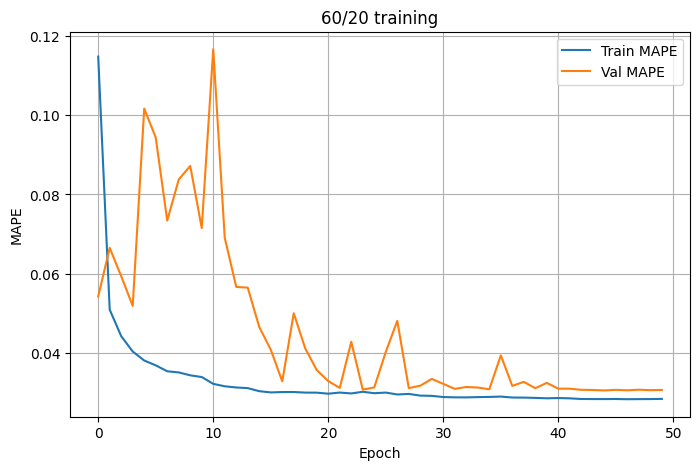

/tmp/ipython-input-3060771020.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


🔒 Internal Test MAPE (frozen 20%): 0.03045


In [12]:
# Train
model_60 = get_model(HYPERPARAMS)
hist_60  = train_model(model_60, train_loader_60, val_loader_20, HYPERPARAMS)
plot_loss(hist_60, title="60/20 training")

# Load BEST checkpoint saved during training
model_60 = get_model(HYPERPARAMS)
model_60.load_state_dict(torch.load("SeismoLabV3+.pth", map_location=device))
model_60.eval()

# Evaluate frozen internal 20%
def eval_mape(model, loader):
    model.eval()
    losses = []
    loss_fn = MAPELoss().to(device)
    with torch.inference_mode(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).squeeze(1)[:, :300, :1259]
            tgt  = yb[:, :300, :1259]
            losses.append(loss_fn(pred, tgt).item())
    return float(np.mean(losses))

internal_test_mape = eval_mape(model_60, test_loader_int)
print(f"🔒 Internal Test MAPE (frozen 20%): {internal_test_mape:.5f}")

# Evaluation- Internal Split

**Quantitative comparison**

In [13]:
def eval_metrics(model, loader):
    model.eval()
    mape_fn = MAPELoss().to(device)
    mae_fn  = nn.L1Loss().to(device)
    mse_fn  = nn.MSELoss().to(device)

    losses = {"MAPE": [], "MAE": [], "RMSE": []}

    with torch.inference_mode(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).squeeze(1)[:, :300, :1259]
            tgt  = yb[:, :300, :1259]

            losses["MAPE"].append(mape_fn(pred, tgt).item())
            losses["MAE"].append(mae_fn(pred, tgt).item())
            losses["RMSE"].append(torch.sqrt(mse_fn(pred, tgt)).item())

    return {k: float(np.mean(v)) for k, v in losses.items()}

metrics = eval_metrics(model_60, test_loader_int)
print(metrics)

/tmp/ipython-input-1458909928.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'MAPE': 0.0304529969021678, 'MAE': 0.08617854474112391, 'RMSE': 0.14567592106759547}


**Qualitative comparison**

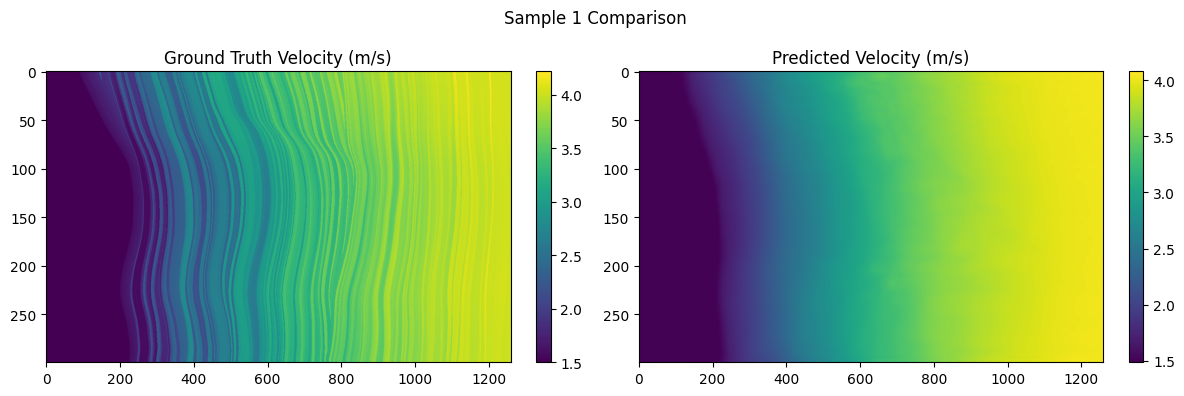

In [18]:
def visualize_prediction(model, dataset, idx=0):
    model.eval()
    xb, yb = dataset[idx]   # single sample
    xb = xb.unsqueeze(0).to(device)  # add batch dimension
    with torch.inference_mode():
        pred = model(xb).squeeze().cpu().numpy()

    pred = pred[:300, :1259]   # crop padded region
    gt   = yb.numpy()[:300, :1259]

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    im0 = axs[0].imshow(gt, aspect='auto', cmap='viridis')
    axs[0].set_title("Ground Truth Velocity (m/s)")
    plt.colorbar(im0, ax=axs[0], fraction=0.046)

    im1 = axs[1].imshow(pred, aspect='auto', cmap='viridis')
    axs[1].set_title("Predicted Velocity (m/s)")
    plt.colorbar(im1, ax=axs[1], fraction=0.046)

    plt.suptitle(f"Sample {idx} Comparison")
    plt.tight_layout()
    plt.show()

visualize_prediction(model_60, test_loader_int.dataset, idx=1)

**Final 80/20 Split & Official Test Loader
Rebuilds dataset with 80% training and 20% validation on all labeled data. Prepares DataLoaders and configures the 150-sample official test set (unlabeled) for inference.**

In [19]:
# Rebuild an 80/20 split on all labeled data
idx_train_80, idx_val_20b = train_test_split(idx_all, test_size=0.20, random_state=42, shuffle=True)
print(f"80/20 Sizes | train: {len(idx_train_80)} | val: {len(idx_val_20b)}")

train_loader_80 = DataLoader(Subset(full_dataset, idx_train_80), batch_size=BATCH_SIZE, shuffle=True, drop_last=True, **loader_args)
val_loader_20b  = DataLoader(Subset(full_dataset, idx_val_20b),  batch_size=1, shuffle=False, **loader_args)

# Official 150-sample test set (no labels)
test_loader_official = DataLoader(SeismicDataset(test_dir, is_test=True), batch_size=4 if cuda else 1, shuffle=False, **loader_args)

80/20 Sizes | train: 1600 | val: 400


**Final Model Training (80/20 Split) & Checkpoint Recovery
Trains DeepLabV3+ on the full 80/20 split, logs learning curves, and restores the best checkpoint for inference and submission.**

/tmp/ipython-input-1914336851.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler   = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
Epoch 1/50 - Train:   0%|          | 0/400 [00:00<?, ?it/s]/tmp/ipython-input-1914336851.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1914336851.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 001/50 | Train MAPE: 0.11119 | Val MAPE: 0.07201 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 002/50 | Train MAPE: 0.04909 | Val MAPE: 0.05346 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 003/50 | Train MAPE: 0.04211 | Val MAPE: 0.06688 | LR: 5.00e-04


Epoch 004/50 | Train MAPE: 0.03920 | Val MAPE: 0.03715 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 005/50 | Train MAPE: 0.03673 | Val MAPE: 0.10203 | LR: 5.00e-04


Epoch 006/50 | Train MAPE: 0.03398 | Val MAPE: 0.14163 | LR: 5.00e-04


Epoch 007/50 | Train MAPE: 0.03350 | Val MAPE: 0.05354 | LR: 5.00e-04


Epoch 008/50 | Train MAPE: 0.03274 | Val MAPE: 0.05878 | LR: 5.00e-04


Epoch 009/50 | Train MAPE: 0.03266 | Val MAPE: 0.09119 | LR: 5.00e-04


Epoch 010/50 | Train MAPE: 0.03256 | Val MAPE: 0.03417 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 011/50 | Train MAPE: 0.03224 | Val MAPE: 0.03392 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 012/50 | Train MAPE: 0.03212 | Val MAPE: 0.04554 | LR: 5.00e-04


Epoch 013/50 | Train MAPE: 0.03170 | Val MAPE: 0.04156 | LR: 5.00e-04


Epoch 014/50 | Train MAPE: 0.03243 | Val MAPE: 0.04712 | LR: 5.00e-04


Epoch 015/50 | Train MAPE: 0.03170 | Val MAPE: 0.07495 | LR: 5.00e-04


Epoch 016/50 | Train MAPE: 0.03131 | Val MAPE: 0.04109 | LR: 5.00e-04


Epoch 017/50 | Train MAPE: 0.03134 | Val MAPE: 0.04749 | LR: 2.50e-04


Epoch 018/50 | Train MAPE: 0.03034 | Val MAPE: 0.04422 | LR: 2.50e-04


Epoch 019/50 | Train MAPE: 0.02999 | Val MAPE: 0.04840 | LR: 2.50e-04


Epoch 020/50 | Train MAPE: 0.02996 | Val MAPE: 0.03266 | LR: 2.50e-04
  ✅ Saved new best model!


Epoch 021/50 | Train MAPE: 0.02942 | Val MAPE: 0.03038 | LR: 2.50e-04
  ✅ Saved new best model!


Epoch 022/50 | Train MAPE: 0.02934 | Val MAPE: 0.03052 | LR: 2.50e-04


Epoch 023/50 | Train MAPE: 0.02923 | Val MAPE: 0.03102 | LR: 2.50e-04


Epoch 024/50 | Train MAPE: 0.02921 | Val MAPE: 0.03050 | LR: 2.50e-04


Epoch 025/50 | Train MAPE: 0.02922 | Val MAPE: 0.03597 | LR: 2.50e-04


Epoch 026/50 | Train MAPE: 0.02915 | Val MAPE: 0.03524 | LR: 2.50e-04


Epoch 027/50 | Train MAPE: 0.02926 | Val MAPE: 0.03070 | LR: 1.25e-04


Epoch 028/50 | Train MAPE: 0.02885 | Val MAPE: 0.03034 | LR: 1.25e-04
  ✅ Saved new best model!


Epoch 029/50 | Train MAPE: 0.02891 | Val MAPE: 0.03032 | LR: 1.25e-04
  ✅ Saved new best model!


Epoch 030/50 | Train MAPE: 0.02887 | Val MAPE: 0.03040 | LR: 1.25e-04


Epoch 031/50 | Train MAPE: 0.02880 | Val MAPE: 0.03091 | LR: 1.25e-04


Epoch 032/50 | Train MAPE: 0.02883 | Val MAPE: 0.03032 | LR: 1.25e-04


Epoch 033/50 | Train MAPE: 0.02876 | Val MAPE: 0.03360 | LR: 1.25e-04


Epoch 034/50 | Train MAPE: 0.02872 | Val MAPE: 0.03029 | LR: 1.25e-04
  ✅ Saved new best model!


Epoch 035/50 | Train MAPE: 0.02873 | Val MAPE: 0.03035 | LR: 1.25e-04


Epoch 036/50 | Train MAPE: 0.02880 | Val MAPE: 0.03078 | LR: 1.25e-04


Epoch 037/50 | Train MAPE: 0.02871 | Val MAPE: 0.03031 | LR: 1.25e-04


Epoch 038/50 | Train MAPE: 0.02868 | Val MAPE: 0.03119 | LR: 1.25e-04


Epoch 039/50 | Train MAPE: 0.02866 | Val MAPE: 0.03050 | LR: 1.25e-04


Epoch 040/50 | Train MAPE: 0.02865 | Val MAPE: 0.03015 | LR: 1.25e-04
  ✅ Saved new best model!


Epoch 041/50 | Train MAPE: 0.02861 | Val MAPE: 0.03118 | LR: 1.25e-04


Epoch 042/50 | Train MAPE: 0.02869 | Val MAPE: 0.03081 | LR: 1.25e-04


Epoch 043/50 | Train MAPE: 0.02862 | Val MAPE: 0.03051 | LR: 1.25e-04


Epoch 044/50 | Train MAPE: 0.02862 | Val MAPE: 0.03021 | LR: 1.25e-04


Epoch 045/50 | Train MAPE: 0.02853 | Val MAPE: 0.02996 | LR: 1.25e-04
  ✅ Saved new best model!


Epoch 046/50 | Train MAPE: 0.02855 | Val MAPE: 0.03158 | LR: 1.25e-04


Epoch 047/50 | Train MAPE: 0.02852 | Val MAPE: 0.03229 | LR: 1.25e-04


Epoch 048/50 | Train MAPE: 0.02854 | Val MAPE: 0.03038 | LR: 1.25e-04


Epoch 049/50 | Train MAPE: 0.02856 | Val MAPE: 0.03012 | LR: 1.25e-04


Epoch 050/50 | Train MAPE: 0.02855 | Val MAPE: 0.03003 | LR: 1.25e-04


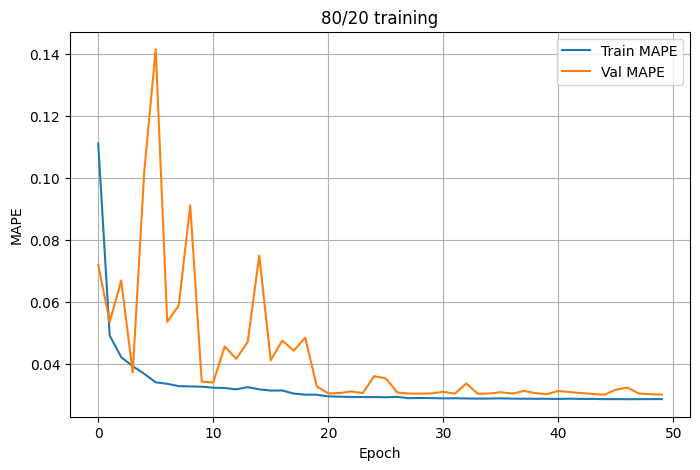

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downs

In [20]:
# Train final model
model_80 = get_model(HYPERPARAMS)
hist_80  = train_model(model_80, train_loader_80, val_loader_20b, HYPERPARAMS)
plot_loss(hist_80, title="80/20 training")

# Load best checkpoint saved in this run
model_80 = get_model(HYPERPARAMS)
model_80.load_state_dict(torch.load("SeismoLabV3+.pth", map_location=device))
model_80.eval()

# Test-time Inference & Submission Builder

Runs batched inference on the 150 official test samples, writes a .npz with (300×1259) float64 predictions per sample ID, validates the file, and exports to Drive.

In [21]:
# Build submission for 150 official test samples
submission_path = "/content/speed_structure_submission.npz"
if os.path.exists(submission_path):
    os.remove(submission_path)

with torch.inference_mode(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
    for xb, sids in tqdm(test_loader_official, desc="Inference (official test)"):
        xb = xb.to(device, non_blocking=True)
        pred = model_80(xb).squeeze(1)[:, :300, :1259]                    # (B, 300, 1259)
        arr  = pred.detach().cpu().numpy().astype(np.float64)
        for i, sid in enumerate(sids):
            create_submission(sid, arr[i], submission_path)

print("✅ Submission written to:", submission_path)

# Sanity check
def validate_submission_file(sub_path, expected=150):
    if not os.path.exists(sub_path): return print("❌ File missing")
    data = np.load(sub_path); keys = list(data.keys())
    print(f"✅ {len(keys)} predictions found.")
    bad = [(k, v.shape, v.dtype) for k, v in data.items() if v.shape != (300,1259) or v.dtype != np.float64]
    if bad: print(f"⚠️ {len(bad)} bad entries:", bad[:3])
    else:   print("🏁 Submission looks good!")

validate_submission_file(submission_path)

# Persist to Drive
!cp -f /content/speed_structure_submission.npz /content/drive/MyDrive/Speed_and_Structure/
print("📁 Copied to Drive: /content/drive/MyDrive/Speed_and_Structure/speed_structure_submission.npz")

/tmp/ipython-input-3003620104.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
Inference (official test): 100%|██████████| 38/38 [02:46<00:00,  4.38s/it]


✅ Submission written to: /content/speed_structure_submission.npz
✅ 150 predictions found.
🏁 Submission looks good!
📁 Copied to Drive: /content/drive/MyDrive/Speed_and_Structure/speed_structure_submission.npz
